In [1]:
import numpy as np
from choclo.prism import gravity_u

# Define a single computation point
easting, northing, upward = 0.0, 0.0, 10.0

# Define the boundaries of the prism as a list
prism = [-10.0, 10.0, -7.0, 7.0, -15.0, -5.0]

# And its density
density = 400.0

# Compute the upward component of the grav. acceleration
g_u = gravity_u(easting, northing, upward, *prism, density)
g_u

-1.6539652880538094e-07

In [2]:
prisms = np.array([
    [-10.0, 0.0, -7.0, 0.0, -15.0, -10.0],
    [-10.0, 0.0, 0.0, 7.0, -25.0, -15.0],
    [0.0, 10.0, -7.0, 0.0, -20.0, -13.0],
    [0.0, 10.0, 0.0, 7.0, -12.0, -8.0],
])
densities = np.array([200.0, 300.0, -100.0, 400.0])

In [3]:
easting = np.linspace(-50.0, 50.0, 21)
northing = np.linspace(-40.0, 40.0, 21)
easting, northing = np.meshgrid(easting, northing)
upward = 10 * np.ones_like(easting)

coordinates = (easting.ravel(), northing.ravel(), upward.ravel())

In [4]:
def gravity_upward_slow(coordinates, prisms, densities):
    """
    Compute the upward component of the acceleration of a set of prisms
    """
    # Unpack coordinates of the observation points
    easting, northing, upward = coordinates[:]
    # Initialize a result array full of zeros
    result = np.zeros_like(easting, dtype=np.float64)
    # Compute the upward component that every prism generate on each
    # observation point
    for i in range(len(easting)):
        for j in range(prisms.shape[0]):
            result[i] += gravity_u(
                easting[i], northing[i], upward[i], *prisms[j, :], densities[j]
            )
    return result

In [5]:
g_u = gravity_upward_slow(coordinates, prisms, densities)

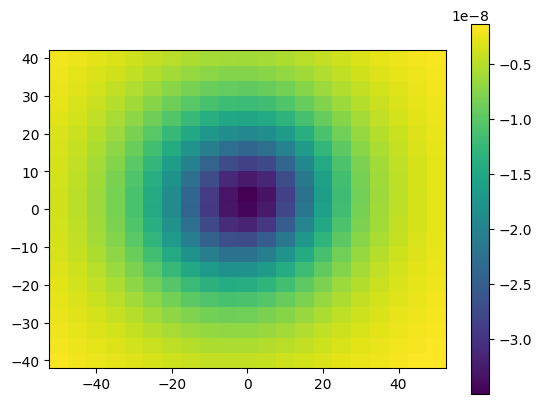

In [6]:
import matplotlib.pyplot as plt

plt.pcolormesh(easting, northing, g_u.reshape(easting.shape), shading='auto')
plt.gca().set_aspect("equal")
plt.colorbar()
plt.show()

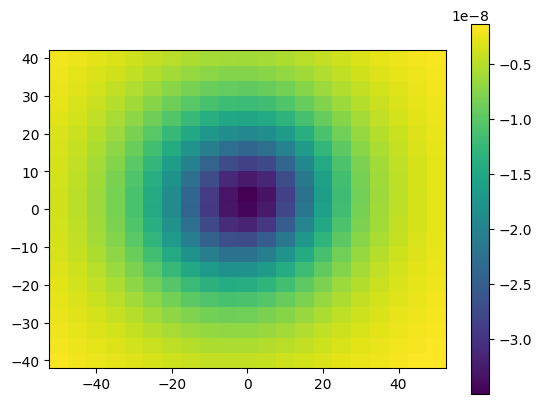

In [7]:
import numba

@numba.jit(nopython=True)
def gravity_upward_jit(coordinates, prisms, densities):
    """
    Compute the upward component of the acceleration of a set of prisms
    """
    # Unpack coordinates of the observation points
    easting, northing, upward = coordinates[:]
    # Initialize a result array full of zeros
    result = np.zeros_like(easting, dtype=np.float64)
    # Compute the upward component that every prism generate on each
    # observation point
    for i in range(len(easting)):
        for j in range(prisms.shape[0]):
            result[i] += gravity_u(
                easting[i],
                northing[i],
                upward[i],
                prisms[j, 0],
                prisms[j, 1],
                prisms[j, 2],
                prisms[j, 3],
                prisms[j, 4],
                prisms[j, 5],
                densities[j],
            )
    return result

g_u = gravity_upward_jit(coordinates, prisms, densities)

plt.pcolormesh(easting, northing, g_u.reshape(easting.shape), shading='auto')
plt.gca().set_aspect("equal")
plt.colorbar()
plt.show()

In [8]:
%timeit gravity_upward_slow(coordinates, prisms, densities)

5.63 ms ± 16.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit gravity_upward_jit(coordinates, prisms, densities)

462 μs ± 3.11 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


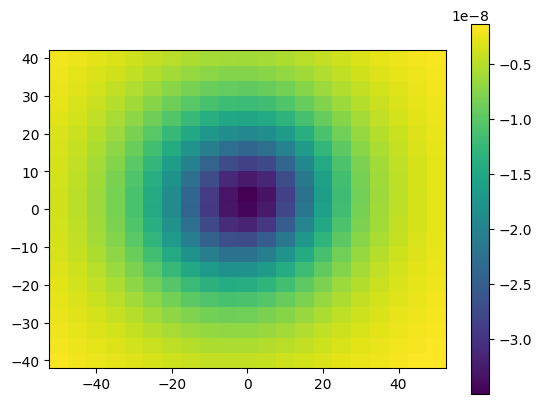

In [10]:
@numba.jit(nopython=True, parallel=True)
def gravity_upward_parallel(coordinates, prisms, densities):
    """
    Compute the upward component of the acceleration of a set of prisms
    """
    # Unpack coordinates of the observation points
    easting, northing, upward = coordinates[:]
    # Initialize a result array full of zeros
    result = np.zeros_like(easting, dtype=np.float64)
    # Compute the upward component that every prism generate on each
    # observation point
    for i in numba.prange(len(easting)):
        for j in range(prisms.shape[0]):
            result[i] += gravity_u(
                easting[i],
                northing[i],
                upward[i],
                prisms[j, 0],
                prisms[j, 1],
                prisms[j, 2],
                prisms[j, 3],
                prisms[j, 4],
                prisms[j, 5],
                densities[j],
            )
    return result

g_u = gravity_upward_parallel(coordinates, prisms, densities)

plt.pcolormesh(easting, northing, g_u.reshape(easting.shape), shading='auto')
plt.gca().set_aspect("equal")
plt.colorbar()
plt.show()

In [11]:
%timeit gravity_upward_jit(coordinates, prisms, densities)

462 μs ± 4.14 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
%timeit gravity_upward_parallel(coordinates, prisms, densities)

201 μs ± 497 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
